<a href="https://colab.research.google.com/github/Fernanda-85/MVP_Machine-Learning/blob/main/mvp_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Machine Learning & Analytics
###**Nome:** Fernanda Figueira

###**Matrícula:** 405202400226633

###**Dataset:** Consumo de café e qualidade do sono

###**Fonte:** Kaggle

### - Projeto de Machine Learning
### - Problema de classificação
### - Objetivo: Analisar e prever a qualidade do sono dos indivíduos de acordo com as variáveis de consumo de café/cafeína.
### - Área de aplicação: Saúde (aplicativos de monitoramento e recomendação de hábitos, previsão da qualidade do sono e pesquisas para triagem e análise dos padrões de sono.)
### - Valor para usuário:
 #### 1) otimizar o consumo de café de modo não afetar a qualidade do sono.
 #### 2) melhorar a qualidade do sono.

### Dataset escolhido:
https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset/data

Arquivo baixado: synthetic_coffee_health_10000.csv


#### Bibliotecas importadas:

In [424]:
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#### Carga do dataset e conferência se está conforme esperado:

In [425]:

# Link bruto do arquivo CSV no GitHub
url = "https://raw.githubusercontent.com/Fernanda-85/MVP_Machine-Learning/main/synthetic_coffee_health_10000.csv"

# Ler o arquivo
df = pd.read_csv(url)

# Visualizar as primeiras linhas
df.head()

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

#### Carga relizada e dataframe bruto adequado!

### Análise exploratória resumida (EDA) - Foco no atributo Sleep_Quality

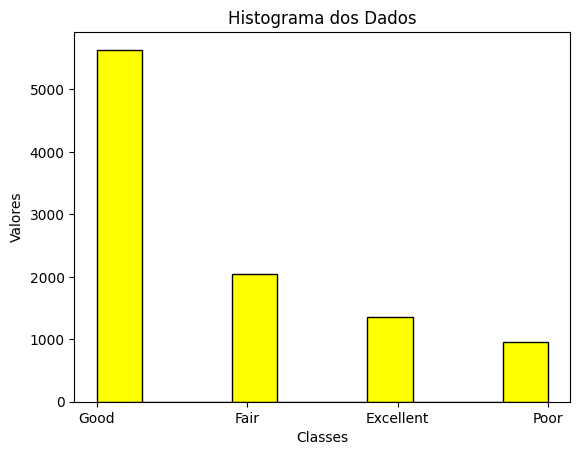

In [451]:

# Criar o histograma
plt.hist(df['Sleep_Quality'], color='yellow', edgecolor='black')
plt.title('Histograma dos Dados')
plt.xlabel('Classes')
plt.ylabel('Valores')
plt.show()


In [434]:
fig = px.histogram(df, x='Sleep_Quality',
title='Distribuição das Classes de Qualidade do Sono',
labels={'Sleep_Quality': 'Qualidade do Sono'}, color='Sleep_Quality')
fig.show()

### Pré-processamento de dados para ajustar parâmetros

In [409]:
# Remoção de colunas irrelevantes
df.drop(columns=["ID", "Country"], inplace=True)

# Remoção de linhas com valores nulos na variável alvo
df = df.dropna(subset=["Sleep_Quality"])

# Preenchimento de valores nulos em outras colunas com a mediana (numéricas) ou modo (categóricas)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

In [410]:
# Verificando a distribuição da variável alvo 'Sleep Quality'
sleep_quality_counts = df['Sleep_Quality'].value_counts()
print(sleep_quality_counts)

Sleep_Quality
Good         5637
Fair         2050
Excellent    1352
Poor          961
Name: count, dtype: int64


#### Realização de balanceamento de dados e visualização do atributo balanceado

In [411]:
# Preparando os dados para balanceamento
X = df.drop(columns=['Sleep_Quality'])
y = df['Sleep_Quality']

# Codificando variáveis categóricas
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=["object"]).columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# Aplicação do SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Combinando os dados balanceados em um novo DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X_encoded.columns)
df_resampled["Sleep_Quality"] = y_resampled
df_resampled



,Age,Gender,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption,Sleep_Quality
0,40,1,3.5,328.100000,7.500000,24.900000,78,1,14.500000,0,2,0,0,Good
1,33,1,1.0,94.100000,6.200000,20.000000,67,1,11.000000,0,3,0,0,Good
2,42,1,5.3,503.700000,5.900000,22.700000,59,2,11.200000,0,1,0,0,Fair
3,53,1,2.6,249.200000,7.300000,24.700000,71,1,6.600000,0,2,0,0,Good
4,32,0,3.1,298.000000,5.300000,24.100000,76,2,8.500000,0,4,0,1,Fair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22543,35,0,1.9,177.352495,4.894001,24.917998,68,0,2.392501,0,3,1,0,Poor
22544,28,1,1.2,116.148330,4.144990,15.876620,61,0,2.951080,0,3,0,0,Poor
22545,18,1,5.0,471.802791,4.400000,18.130303,80,0,13.799203,0,0,0,0,Poor
22546,30,0,0.0,0.246000,4.090000,24.106001,74,0,10.346002,0,1,0,1,Poor


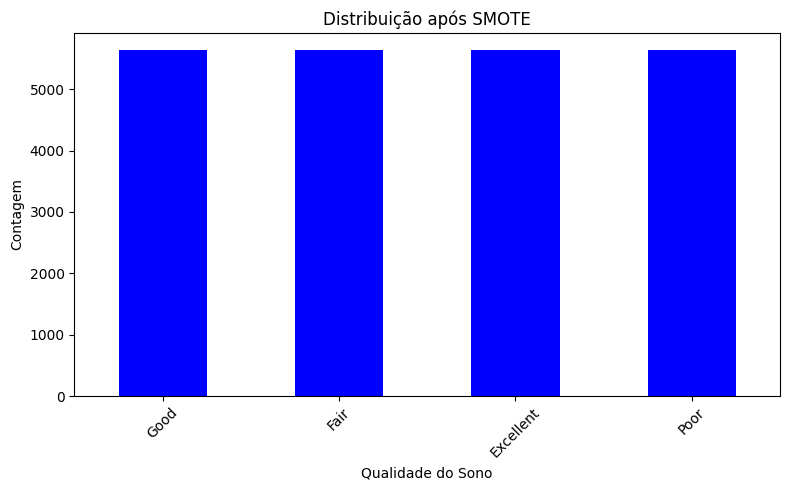

In [412]:
# Visualização da distribuição após SMOTE
plt.figure(figsize=(8, 5))
pd.Series(y_resampled).value_counts().plot(kind='bar', color='blue')
plt.title('Distribuição após SMOTE')
plt.xlabel('Qualidade do Sono')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [413]:
# Verificação da distribuição da variável alvo 'Sleep Quality' após balanceamento
sleep_quality_counts = df_resampled['Sleep_Quality'].value_counts()
print(sleep_quality_counts)

Sleep_Quality
Good         5637
Fair         5637
Excellent    5637
Poor         5637
Name: count, dtype: int64


#### Codificação das variáveis categóricas

In [414]:
# Codificar variáveis categóricas
label_cols = df_resampled.select_dtypes(include="object").columns
le = LabelEncoder()
for col in label_cols:
    df_resampled[col] = le.fit_transform(df_resampled[col])





#### Separação das variáveis independentes e alvo e Normalização das variáveis numéricas

In [415]:
# Separar variáveis independentes e alvo
X = df_resampled.drop(columns=['Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours'])
y = df_resampled["Sleep_Quality"]

# Normalizar variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Conferindo as colunas e os tipos de instâncias após ajustes

In [416]:
print(f"Total de instâncias: {len(df_resampled)}")
print("\nTipos de dados por coluna:")
df_resampled.info()

Total de instâncias: 22548

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22548 entries, 0 to 22547
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      22548 non-null  int64  
 1   Gender                   22548 non-null  int64  
 2   Coffee_Intake            22548 non-null  float64
 3   Caffeine_mg              22548 non-null  float64
 4   Sleep_Hours              22548 non-null  float64
 5   BMI                      22548 non-null  float64
 6   Heart_Rate               22548 non-null  int64  
 7   Stress_Level             22548 non-null  int64  
 8   Physical_Activity_Hours  22548 non-null  float64
 9   Health_Issues            22548 non-null  int64  
 10  Occupation               22548 non-null  int64  
 11  Smoking                  22548 non-null  int64  
 12  Alcohol_Consumption      22548 non-null  int64  
 13  Sleep_Quality        

### Separação em conjuntos de treino e testes e realização de Validação Cruzada

In [417]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 42 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_resampled.values
X_scaled = array[:, 0:13]
y = array [:,13]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
test_size=test_size, shuffle = True, random_state=seed, stratify=y)

#Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação



### Lista de modelos e ensambles de algoritmo de classificação

In [418]:
np.random.seed(seed) #definindo uma semente global
num_trees = 100
max_features = 3

# Lista que armazenará os modelos
models = []

# Criando modelos e adicionando na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('CART', DecisionTreeClassifier()))

# Criando ensembles e adicionando na lista de modelos
models.append(('RF', RandomForestClassifier(n_estimators= num_trees, max_features= max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators= num_trees, max_features= max_features)))


#### Os modelos listados abaixo foram testados e comparados com base na acurácia e no desvio padrão:
#### - Regressão Logística (LR)
####- Árvore de Decisão (CART)
####- Random Forest (RF)
####- Extra Trees (ET)


LR: 0.909524 (0.004821)
CART: 0.996396 (0.001030)
RF: 0.996563 (0.001354)
ET: 0.994734 (0.002150)


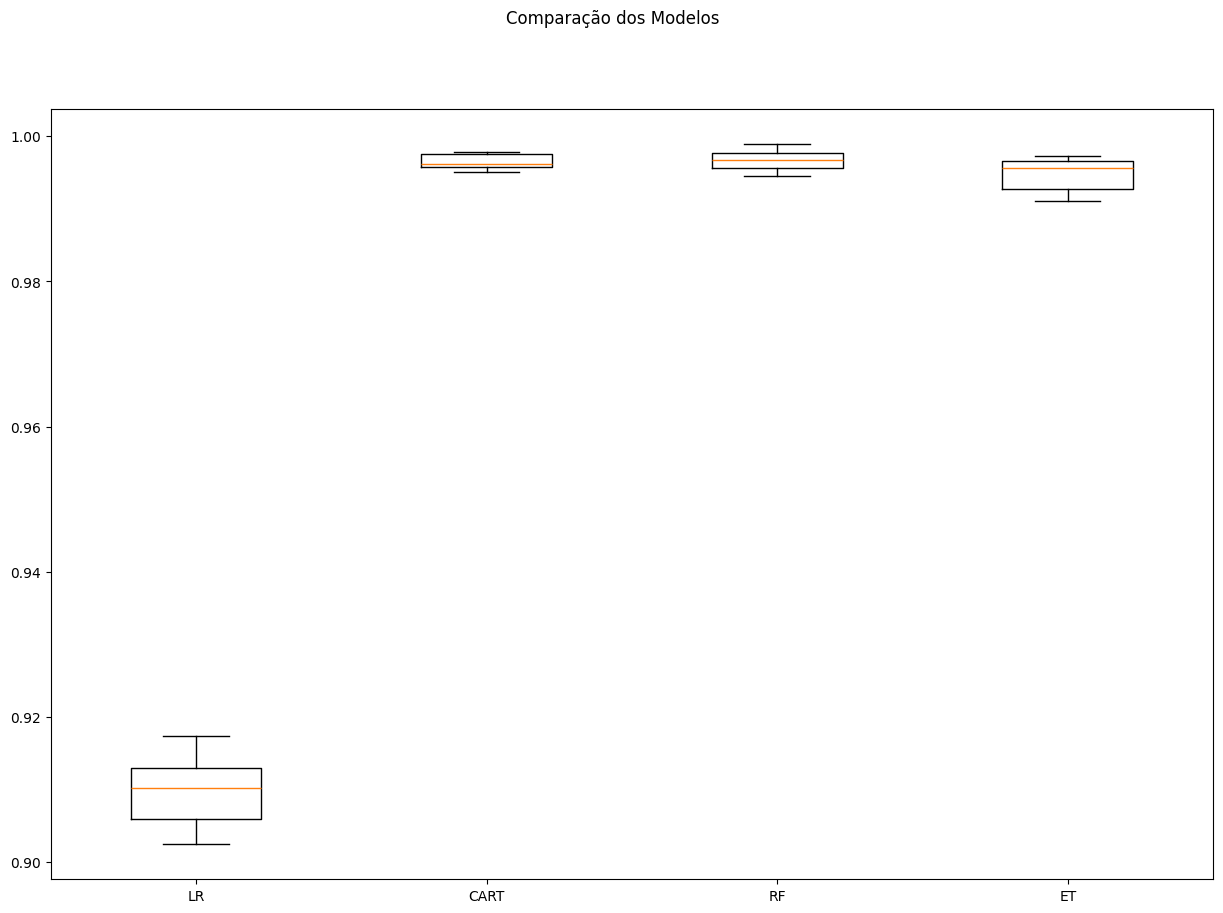

In [419]:
# Lista para armazenar os resultados
results = []
names = []

#Avaliação dos modelos
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

#Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



#### O Random Forest (RF) teve melhor desempenho, com alta acurária e boa estabilidade, sendo escolhindo para ser treinado e utilizado na produção dos resultados.

In [420]:
#Avaliação do modelo com o conjunto de testes

#Preparação do modelo
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model =  RandomForestClassifier(n_estimators= num_trees, max_features= max_features)
model.fit(rescaledX, y_train)

#Estimativa de acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))



0.9955654101995566


In [421]:
#Preparação do modelo como todo o dataset
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
model.fit(rescaledX, y)

RandomForestClassifier(max_features=3)

In [422]:
# Novos dados - não sabemos a classe!
data = {'Coffee_Intake': [90, 7, 6, 20],
        'Caffeine_mg': [2000, 307.2, 125.8, 950.0],
        'Sleep_Hours': [8.8, 6.9, 7.0, 4.1],
        'Age': [22, 19, 52, 68],
        'Gender':[1, 0, 1, 0],
        'BMI': [23.9, 25.1, 24.2, 34.6],
        'Heart_Rate':	[68, 72, 77, 95],
        'Stress_Level': [0, 1, 1, 3],
        'Physical_Activity_Hours': [18, 16, 15, 5],
        'Health_Issues': [0, 0, 0, 1],
        'Occupation': [1, 4, 3, 4],
        'Smoking': [0, 0, 0, 1],
        'Alcohol_Consumption': [0, 0, 1, 1]
        }

atributos = ['Coffee_Intake',	'Caffeine_mg', 'Sleep_Hours', 'Age', 'Gender',	'BMI',	'Heart_Rate',	'Stress_Level',
             'Physical_Activity_Hours',	'Health_Issues',	'Occupation',	'Smoking',	'Alcohol_Consumption']
entrada = pd.DataFrame (data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

#Padronização nos dados de entrada ussando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)




[[ 5.16428975e+00  3.94765681e+03 -4.29207545e+00 -5.15978427e+00
   0.00000000e+00  4.07332036e+00  3.25212582e+02 -1.37587682e+00
   5.72205898e+01 -4.64741292e-01 -4.47213595e-01]
 [-2.57884320e+00  6.05723581e+02 -4.82762119e+00 -5.47997094e+00
  -1.41421356e+00  4.37111458e+00  3.44355094e+02 -5.93823564e-01
   5.08237220e+01 -4.64741292e-01  2.23606798e+00]
 [-2.67213396e+00  2.47602900e+02 -4.79943457e+00 -1.95791755e+00
   0.00000000e+00  4.14776891e+00  3.68283234e+02 -5.93823564e-01
   4.76252881e+01 -4.64741292e-01  1.34164079e+00]
 [-1.36606334e+00  1.87474218e+03 -5.61684649e+00 -2.50255298e-01
  -1.41421356e+00  6.72865215e+00  4.54424538e+02  9.70282939e-01
   1.56409490e+01  2.15173478e+00  2.23606798e+00]]


In [423]:
# Predição de classes para novos dados
saidas = model.predict(rescaledEntradaX)
print(saidas)

[2. 3. 2. 3.]


### Conclusão:

#### O projeto demonstrou que é possível prever com alta precisão a qualidade do sono utilizando algoritimo de machine learning. O tratamento adequado dos dados e a escolha de modelos robustos são essenciais para o sucesso da abordagem.
#### Podemos aprimorar o projeto, incluíndo outras variáveis na análise, como prática de atividades físicas, consumo de bebidas alcoólicas, uso de remédios e entopecentes etc.